**1. LOAD REQUIRED PACKAGES**

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from joblib import dump, load
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

**2. LOAD AND PREPARE THE DATA**

**2A. Load the processed data**

In [3]:
from src.data.jason_sets import load_sets
train_scaled, target, X_val, y_val, test_scaled, y_test, test_id = load_sets()

**2B. Load the raw data**

In [4]:
train = pd.read_csv('../data/raw/train.csv')
train.drop('Id', axis=1, inplace=True)
train.rename(columns={'3P Made': '3PM'}, inplace=True)

test = pd.read_csv('../data/raw/test.csv')
test.drop('Id', axis=1, inplace=True)
test.rename(columns={'3P Made': '3PM'}, inplace=True)

**3. EXPLORATORY DATA ANALYSIS**

**3A. Find outliers**

There're no outliers in the train data

In [5]:
X = train[train.columns[:-1]]

outliers = X[np.abs(stats.zscore(X) >= 3).all(axis=1)]
print(f'Numbes of outliers in the features: {outliers.shape}', '\n')
outliers.head()

Numbes of outliers in the features: (0, 19) 



Empty DataFrame
Columns: [GP, MIN, PTS, FGM, FGA, FG%, 3PM, 3PA, 3P%, FTM, FTA, FT%, OREB, DREB, REB, AST, STL, BLK, TOV]
Index: []

**3B. Find the difference between classes in each feature**

We used the features' `median` values to compare the differences between the two type of players.

In [6]:
class_diff = train.groupby(['TARGET_5Yrs']).median()
class_diff

GP   MIN  PTS  FGM  FGA   FG%  3PM  3PA   3P%  FTM  FTA   FT%  \
TARGET_5Yrs                                                                  
0            53  13.5  4.7  1.8  4.2  42.1  0.2  0.8  19.9  0.8  1.2  70.6   
1            64  17.6  6.7  2.6  5.7  44.9  0.3  0.8  19.4  1.3  1.8  71.5   

             OREB  DREB  REB  AST  STL  BLK  TOV  
TARGET_5Yrs                                       
0             0.6   1.4  2.0  1.0  0.5  0.2  0.9  
1             1.0   2.0  3.0  1.3  0.6  0.2  1.2

**Express the differences as variances**

In [7]:
class_diff.pct_change()

GP       MIN       PTS       FGM       FGA       FG%  3PM  \
TARGET_5Yrs                                                                    
0                 NaN       NaN       NaN       NaN       NaN       NaN  NaN   
1            0.207547  0.303704  0.425532  0.444444  0.357143  0.066508  0.5   

             3PA       3P%    FTM  FTA       FT%      OREB      DREB  REB  \
TARGET_5Yrs                                                                 
0            NaN       NaN    NaN  NaN       NaN       NaN       NaN  NaN   
1            0.0 -0.025126  0.625  0.5  0.012748  0.666667  0.428571  0.5   

             AST  STL  BLK       TOV  
TARGET_5Yrs                           
0            NaN  NaN  NaN       NaN  
1            0.3  0.2  0.0  0.333333

**3B. Visualise the range of values by class in each feature**

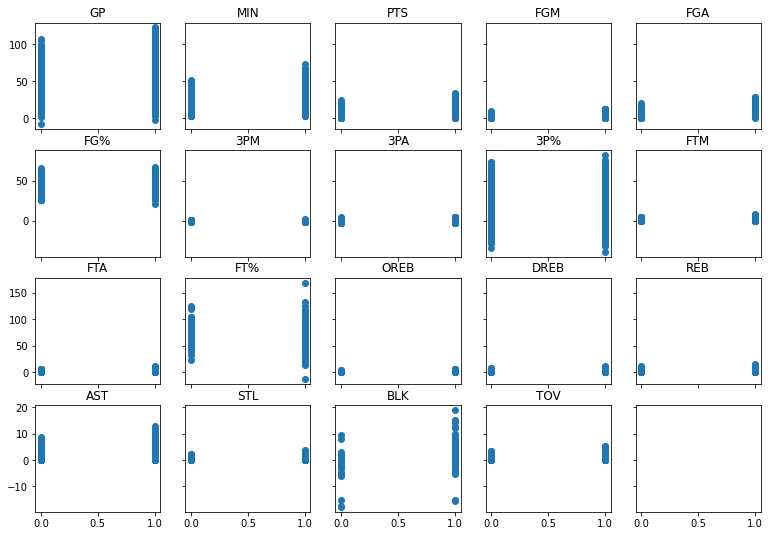

In [8]:
fig, ax = plt.subplots(4, 5, sharex='col', sharey='row', figsize=(13,9))

k = 0
for i in range(4):
    for j in range(5):
        if k < 19:
            ax[i, j].scatter(train['TARGET_5Yrs'], train.iloc[:, k])
            ax[i, j].set_title(train.columns[k])
            k +=1

**3C. Visualise the relationship between pair of features**

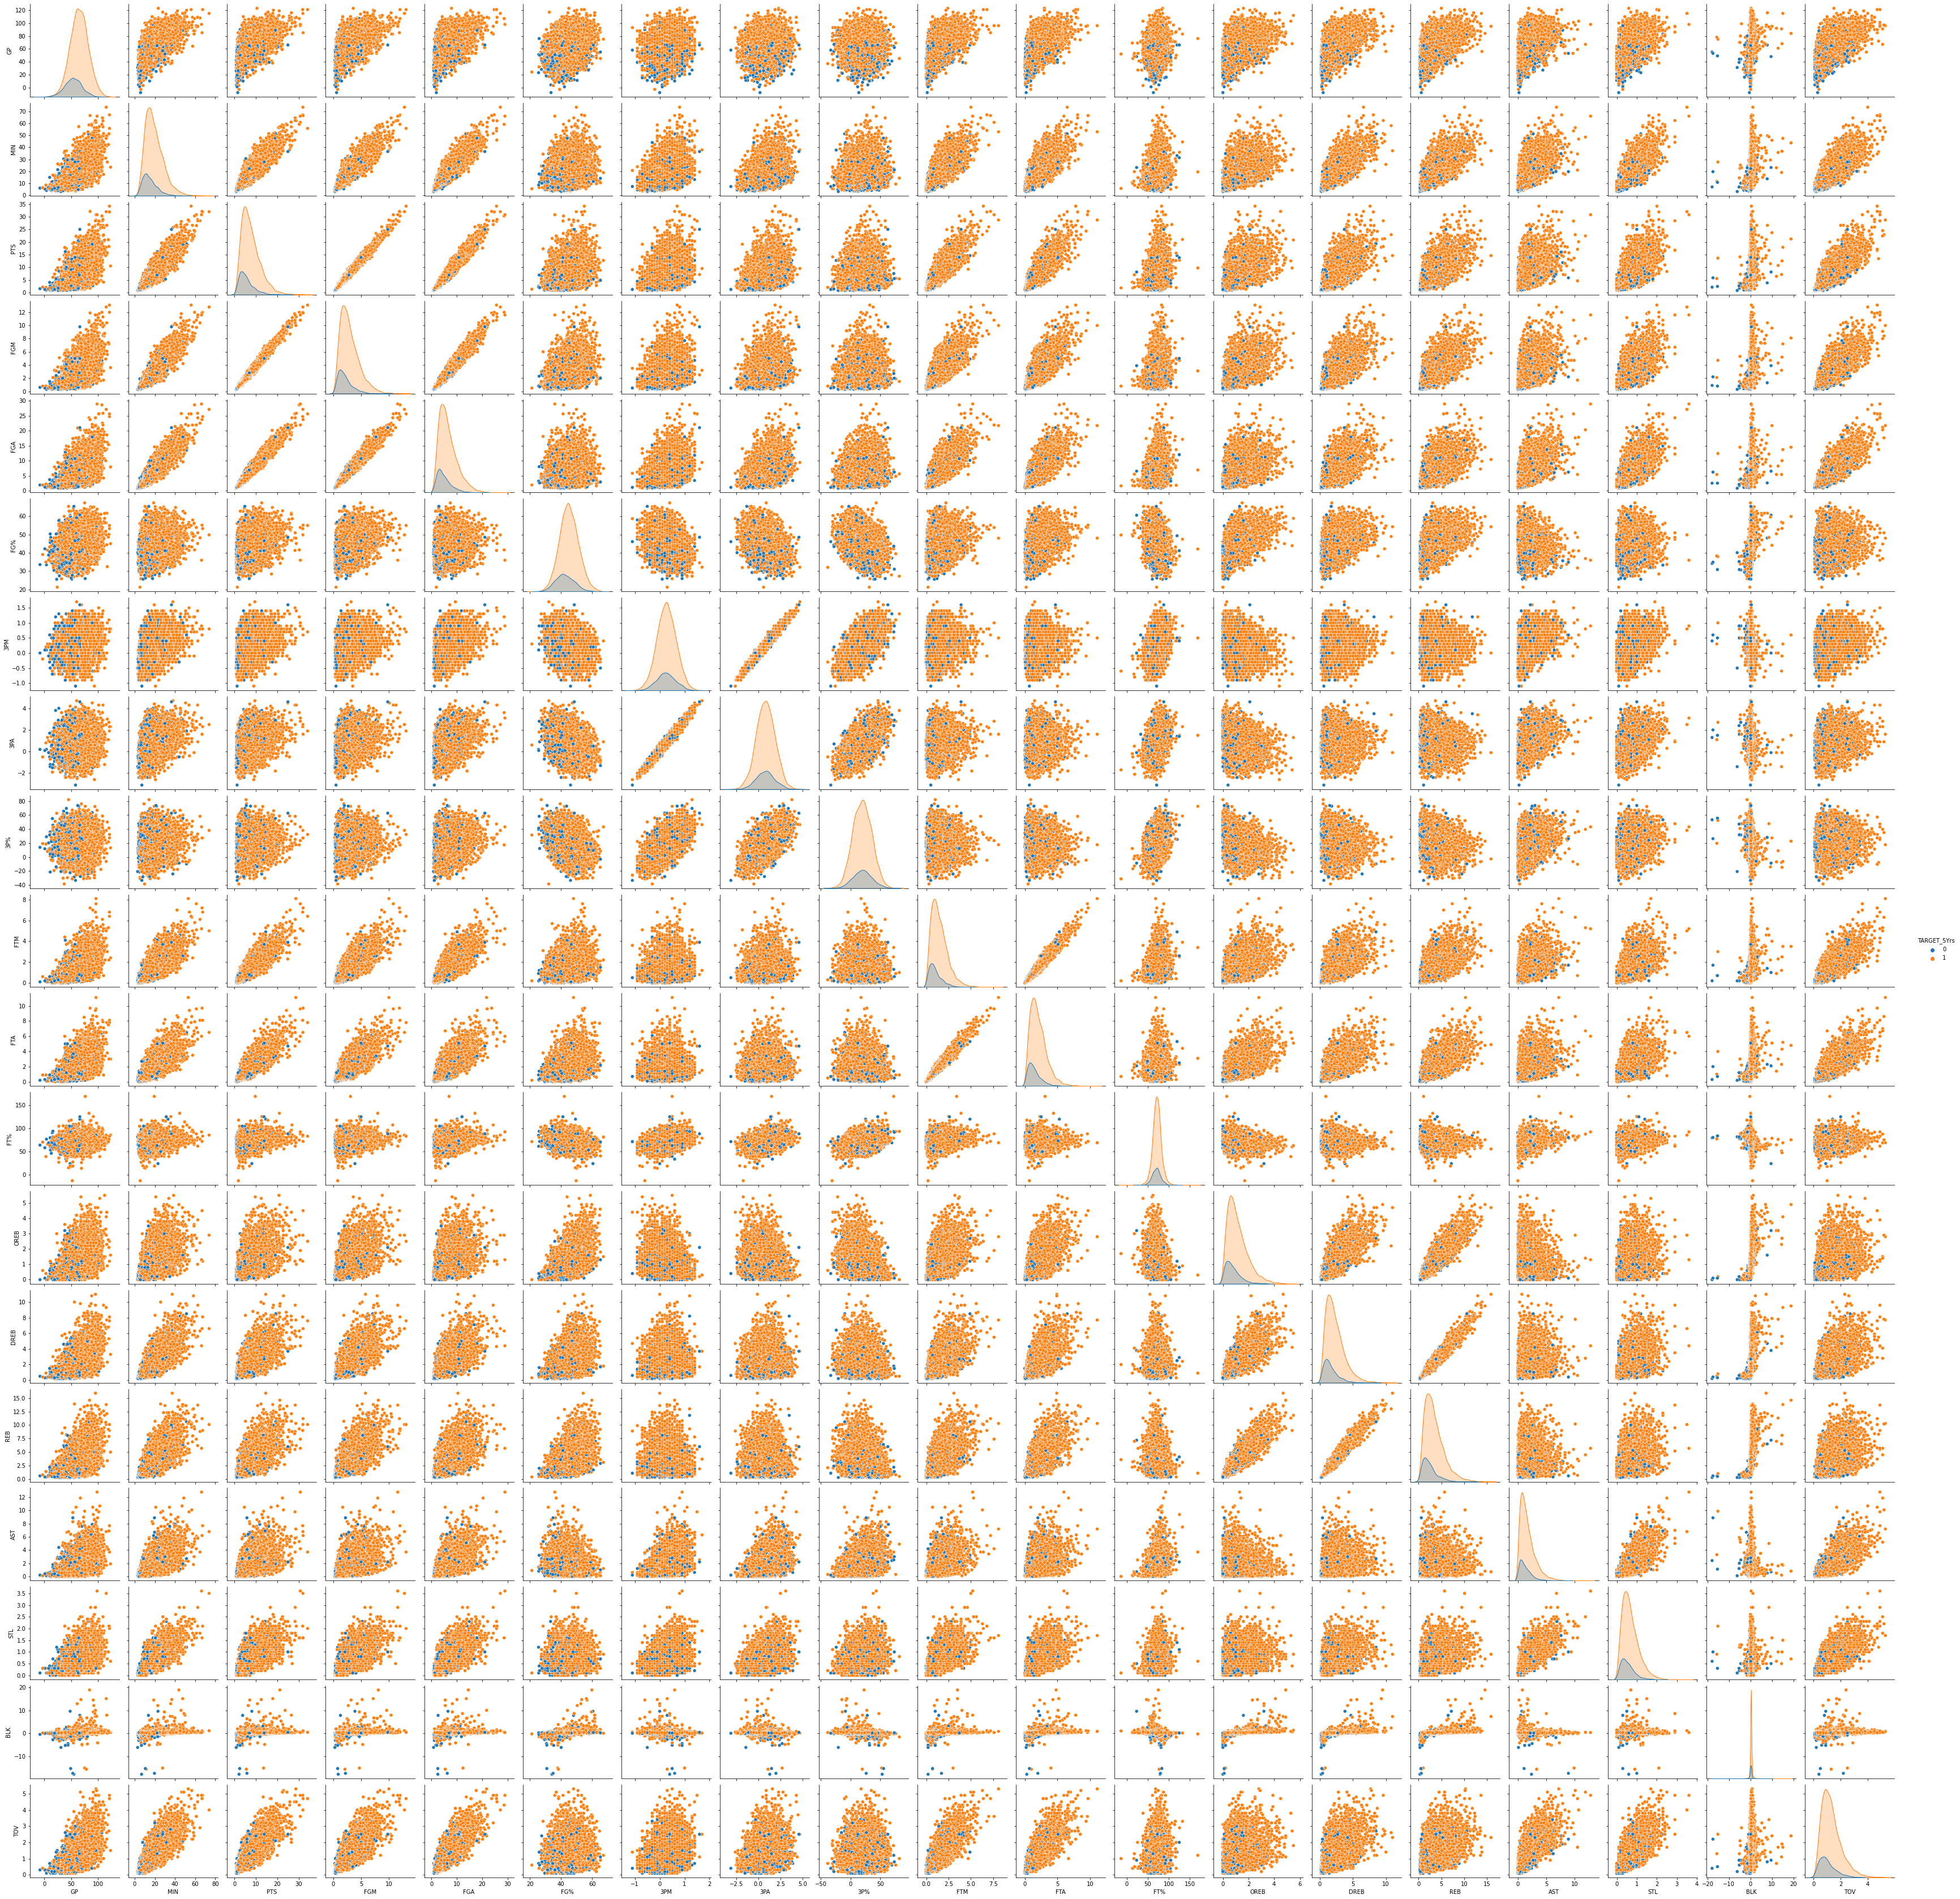

In [9]:
sns.pairplot(train, hue='TARGET_5Yrs')
plt.savefig('../reports/figures/relationship_scatter.png')
plt.show()

**3D. Visualise the correlation between pair of features**

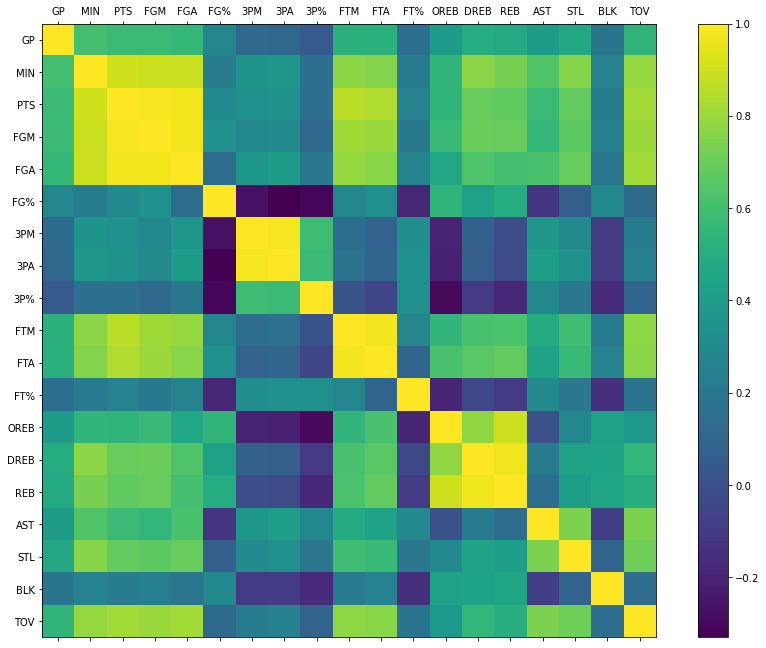

In [10]:
X = train[train.columns[:-1]]

f = plt.figure(figsize=(15, 11))
plt.matshow(X.corr(), fignum=f.number)
plt.xticks(ticks=range(0,19), labels=X.columns)
plt.yticks(ticks=range(0,19), labels=X.columns)
plt.colorbar()
plt.savefig('../reports/figures/correlation_heatmap.png')
plt.show()

**3E. Detect multicollinearity between features**

In [11]:
X = train[train.columns[:-1]]
          
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data.sort_values(by='VIF', ascending=False))

   feature         VIF
2      PTS  919.713189
3      FGM  651.006231
14     REB  493.186803
13    DREB  248.500868
9      FTM  220.842706
4      FGA  219.136362
10     FTA  177.160411
5      FG%  103.450790
11     FT%  101.242822
1      MIN   71.307025
12    OREB   64.153889
7      3PA   49.632837
6      3PM   43.827430
0       GP   24.769528
18     TOV   23.093078
16     STL   11.957640
15     AST   10.751873
8      3P%    4.400127
17     BLK    1.449076


**4. APPROACH 1: USING PRINCIPLE COMPONENT ANALYSIS (PCA)** 

**4A. Find the optimum number of components**

The scree plot shows that 10 components can explain 98% of the variations in the data.

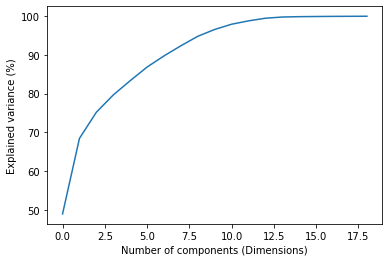

In [12]:
df_train = pd.DataFrame(train_scaled, columns=train.columns[:-1])
df_test = pd.DataFrame(test_scaled, columns=test.columns)

pca = PCA(n_components=None)
pca.fit(df_train)

# Make the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")
plt.show()

**4B. Transform the train and test data into 10 PCA components**

In [13]:
pca = PCA(n_components=10)

train_pca = pca.fit_transform(df_train)
test_pca = pca.transform(df_test)

**4C. Evaluate PCA performance**

In [14]:
from src.models.jason_train_model import classification_model

logistic = LogisticRegression()
classification_model(logistic, train_pca, target)

0.6996204245979243

**4D. Tune Logistic Regression (LG) with the PCA tranformed train data**

In [15]:
from src.models.jason_tune_model import searchCV

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers, penalty=penalty, C=c_values)
logistic = LogisticRegression()

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
searchCV(logistic, grid, train_pca, target, kfold)

Best params: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Training AUC score: 0.700


**4E. Train the tuned LG with the data oversmapled by SMOTE and save prediction result**

In [16]:
from src.models.jason_predict_model import save_prediction

oversample = SMOTE(random_state=2)
X_smote, y_smote = oversample.fit_resample(train_pca, target)

lg_tuned_1 = LogisticRegression(C=0.01, penalty='l2', solver='liblinear')
lg_tuned_1.fit(X_smote, y_smote)

dump(lg_tuned_1,  '../models/jason_lg_tuned_pca_smote.joblib')
save_prediction(lg_tuned_1, test_pca, test_id, 'jason_lg_tuned_pca_smote_pred')

**5. APPROACH 2: USE DOMAIN KNOWLEDGE**

**5A. Method 1: based on CARMELO NBA Player Projection**



**Engineering new features**

In [17]:
df_train['eFG%'] = (df_train['FGM'] + 0.5*df_train['3PM']) / df_train['FGA']    # Effective field goal percentage
df_train['TS%'] = df_train['PTS'] / 2*(df_train['FGA'] + 0.44*df_train['FTA'])  # True shooting percentage
df_train['FTF'] = df_train['FTA'] / df_train['FGA']                              # Free throw frequency

df_test['eFG%'] = (df_test['FGM'] + 0.5*df_test['3PM']) / df_test['FGA']
df_test['TS%'] = df_test['PTS'] / 2*(df_test['FGA'] + 0.44*df_test['FTA'])
df_test['FTF'] = df_test['FTA'] / df_test['FGA']

**Evaluate the LG trained with the selected features**

We didn't pursue this option further because it had lower cross validation AUC score compared to the the PCA option above.

In [18]:
select_1 = ['3P%', 'FT%', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'eFG%', 'TS%', 'FTF']
train_select_1 = df_train[select_1]
test_select_1 = df_test[select_1]

logistic = LogisticRegression()
classification_model(logistic, train_select_1, target)

0.6599841916583548

**5B. Method 2: based on Hollinger's Player Efficiency Rating PER**

**Engineering the new feature PER**

In [19]:
df_train['PER'] = (85.910*df_train['FGM'] + 53.897*df_train['STL'] + 51.757*df_train['3PM'] + 46.845*df_train['FTM'] + 
                39.190*df_train['BLK'] + 39.190*df_train['OREB'] + 34.677*df_train['AST'] + 14.707*df_train['DREB']) / df_train['MIN']

df_test['PER'] = (85.910*df_test['FGM'] + 53.897*df_test['STL'] + 51.757*df_test['3PM'] + 46.845*df_test['FTM'] + 
               39.190*df_test['BLK'] + 39.190*df_test['OREB'] + 34.677*df_test['AST'] + 14.707*df_test['DREB']) / df_test['MIN']

**Evaluate the LG trained with the selected features**

In [20]:
select_2 = ['GP', 'PTS', 'FGA', 'FTA', 'REB', 'TOV', 'PER']
train_select_2 = df_train[select_2]
test_select_2 = df_test[select_2]

logistic = LogisticRegression()
classification_model(logistic, train_select_2, target)

0.69548967290007

**Tune an LG with the selected features**

In [21]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers, penalty=penalty, C=c_values)
logistic = LogisticRegression()

searchCV(logistic, grid, train_select_2, target, kfold)

Best params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Training AUC score: 0.697


**Train the tuned LG with the data oversmapled by SMOTE and save prediction result**

In [22]:
oversample = SMOTE(random_state=2)
X_smote, y_smote = oversample.fit_resample(train_select_2, target)

lg_tuned_2 = LogisticRegression(C=10, penalty='l2', solver='liblinear')
lg_tuned_2.fit(X_smote, y_smote)

dump(lg_tuned_2,  '../models/jason_lg_tuned_smote_select_2.joblib')
save_prediction(lg_tuned_2, test_select_2, test_id, 'jason_lg_tuned_smote_select_2_pred')

**6. APPROACH 3: USE STATISTICAL ANALYSIS**

**6A. Select important features to train a default LG and evaluate its performance**

We selected features with large differences between the classes' medican values (refer to 3B above).

In [23]:
select_3 = ['GP', 'MIN', 'PTS', '3PM', 'FTM', 'FTA',
            'OREB', 'DREB', 'REB', 'AST', 'STL', 'TOV']           
train_select_3 = df_train[select_3]
test_select_3 = df_test[select_3]

logistic = LogisticRegression()
classification_model(logistic, train_select_3, target)

0.6954368436285573

**6B. Tune an LG with selected features**

In [24]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers, penalty=penalty, C=c_values)
logistic = LogisticRegression()

searchCV(logistic, grid, train_select_3, target, kfold)

Best params: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Training AUC score: 0.696


**6C. Train the tuned LG with data oversmapled by SMOTE and save prediction result**

In [25]:
oversample = SMOTE(random_state=2)
X_smote, y_smote = oversample.fit_resample(train_select_3, target)

lg_tuned_3 = LogisticRegression(C=0.01, penalty='l2', solver='liblinear')
lg_tuned_3.fit(X_smote, y_smote)

dump(lg_tuned_3,  '../models/jason_lg_tuned_smote_select_3.joblib')
save_prediction(lg_tuned_3, test_select_3, test_id, 'jason_lg_tuned_smote_select_3_pred')